In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [135]:
dataset = pd.read_csv('data_analyzed/0.csv',index_col="time",parse_dates=True)
df = pd.read_csv('data_by_id/0.csv', index_col="time",parse_dates=True)
df = df[4:]
df.head()

,adjusted_open,adjusted_high,adjusted_low,adjusted_close,adjusted_volume,id,moving_average
time,,,,,,,
1999-11-26,27.696743,28.116802,27.608667,27.906772,1237100.0,0,28.032790
1999-11-29,27.778045,28.753664,27.479939,28.543635,2914700.0,0,28.269920
1999-11-30,28.455558,29.092421,27.737394,28.584286,3083000.0,0,28.024660
1999-12-01,28.584286,29.431177,28.374257,29.092421,2115400.0,0,28.389162
1999-12-02,29.641207,30.488098,29.261799,29.898662,2195900.0,0,28.805155


In [165]:
column = df['adjusted_open'].count()

print(column)

4553


In [166]:
df.isna().any()

adjusted_open      False
adjusted_high      False
adjusted_low       False
adjusted_close     False
adjusted_volume    False
id                 False
moving_average     False
dtype: bool

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4553 entries, 1999-11-26 to 2017-12-29
Data columns (total 7 columns):
adjusted_open      4553 non-null float64
adjusted_high      4553 non-null float64
adjusted_low       4553 non-null float64
adjusted_close     4553 non-null float64
adjusted_volume    4553 non-null float64
id                 4553 non-null int64
moving_average     4553 non-null float64
dtypes: float64(6), int64(1)
memory usage: 444.6 KB


In [168]:
training_set = df.drop(['id'], axis=1)
# training_set
# training_set.head()

In [169]:
def change_category(now, week_from_now):
    ratio = float(week_from_now)/now
    percentile = (ratio - 1) * 100
    if abs(percentile) >= 5:
        return np.sign(percentile) * 3
    elif abs(percentile) >= 3:
        return np.sign(percentile) * 2
    elif abs(percentile) >= 2:
        return np.sign(percentile)
    else:
        return 0

In [170]:
# Convert to percentage
training_set_percentage = training_set.copy()
for i, data in enumerate(training_set_percentage):
#     print(training_set_percentage[data])
    for index, price in enumerate(training_set_percentage[data]):
        if index > training_set_percentage.shape[0] - 6:
            break
#         print(training_set_percentage[data][index])
#         print(change_category(training_set_percentage[data][index], training_set[data][index+5]))
        training_set_percentage[data][index] = change_category(training_set[data][index], training_set[data][index+5])
training_set_percentage = training_set_percentage.iloc[:-6]
column = column - 6
print(column)
training_set_percentage.shape

4547


(4547, 6)

In [182]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
# training_set_scaled = sc.fit_transform(training_set_percentage)
training_set_scaled.shape

(4547, 6)

In [172]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, column-100):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, :])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))

X_train.shape

(4387, 60, 6)

In [173]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 6)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 6))

In [174]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
4387/4387 [==============================] - 29s 7ms/step - loss: 0.1330
Epoch 2/10
4387/4387 [==============================] - 28s 6ms/step - loss: 0.1160
Epoch 3/10
4387/4387 [==============================] - 28s 6ms/step - loss: 0.0785
Epoch 4/10
4387/4387 [==============================] - 27s 6ms/step - loss: 0.0699
Epoch 5/10
4387/4387 [==============================] - 26s 6ms/step - loss: 0.0680
Epoch 6/10
4387/4387 [==============================] - 26s 6ms/step - loss: 0.0669
Epoch 7/10
4387/4387 [==============================] - 26s 6ms/step - loss: 0.0647
Epoch 8/10
4387/4387 [==============================] - 29s 7ms/step - loss: 0.0635
Epoch 9/10
4387/4387 [==============================] - 35s 8ms/step - loss: 0.0637
Epoch 10/10
4387/4387 [==============================] - 30s 7ms/step - loss: 0.0629


In [175]:
X_test = []
y_test = []
for i in range(column-100, column):
    X_test.append(training_set_scaled[i-60:i, :])
    y_test.append(training_set_scaled[i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))
y_predicted = regressor.predict(X_test)
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [176]:
y_predicted = pd.DataFrame(y_predicted)
y_predicted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
0    100 non-null float32
1    100 non-null float32
2    100 non-null float32
3    100 non-null float32
4    100 non-null float32
5    100 non-null float32
dtypes: float32(6)
memory usage: 2.4 KB


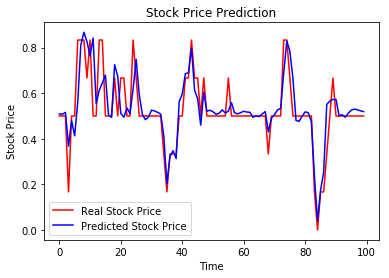

In [180]:
# Visualising the results
plt.plot(training_set_scaled[column-100:, 0], color = 'red', label = 'Real Stock Price')
plt.plot(y_predicted[0], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

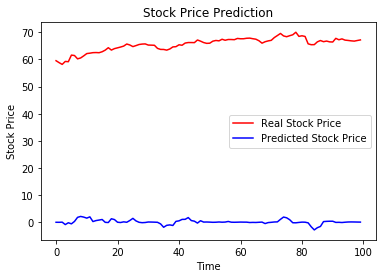

In [179]:
y_real = sc.inverse_transform(y_predicted)
# y_real.shape
training_set.tail(100)['adjusted_open'].values

plt.close()
plt.plot(training_set.tail(100)['adjusted_open'].values, color = 'red', label = 'Real Stock Price')
plt.plot(y_real[:, 0], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# Try add/remove layers
# Change dimensionality of layers
# Split training/test/validation
# Test on specific stocks 
# Combine all stocks into single dataset (60day windows for all stocks)
# Change output dimensionality (predict only open)

In [181]:
regressor.save('test.h5')